# Load data and enviroment

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, udf, mean, count, desc
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinHashLSH, PCA
from pyspark.ml.linalg import VectorUDT, SparseVector
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
spark = SparkSession.builder \
    .appName("Heart_Prediction") \
    .config("spark.driver.memory", "24g") \
    .config("spark.executor.memory", "24g") \
    .config("spark.executor.cores", "8") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

# EDA

In [ ]:
heart_target=spark.read.csv('/content/drive/MyDrive/datasets_final/heart_2022_with_nans.csv', header=True, inferSchema=True)

heart_target.printSchema()

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: double (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

In [ ]:
# Get the number of rows
num_rows = heart_target.count()

# Get the number of columns
num_columns = len(heart_target.columns)

# Print the shape
print((num_rows, num_columns))


(445132, 40)


In [ ]:
heart_target.show()

+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBathing|Diffi

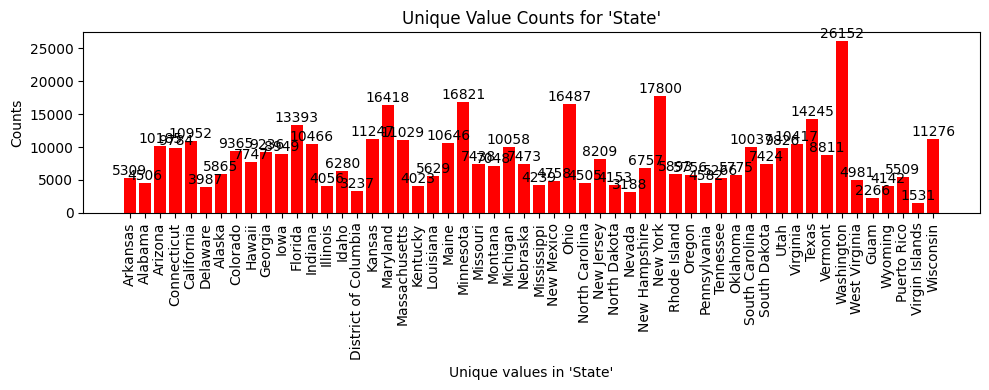

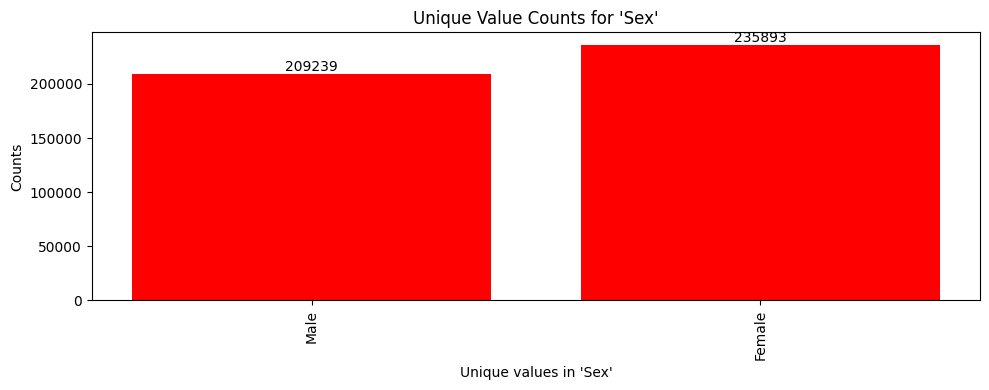

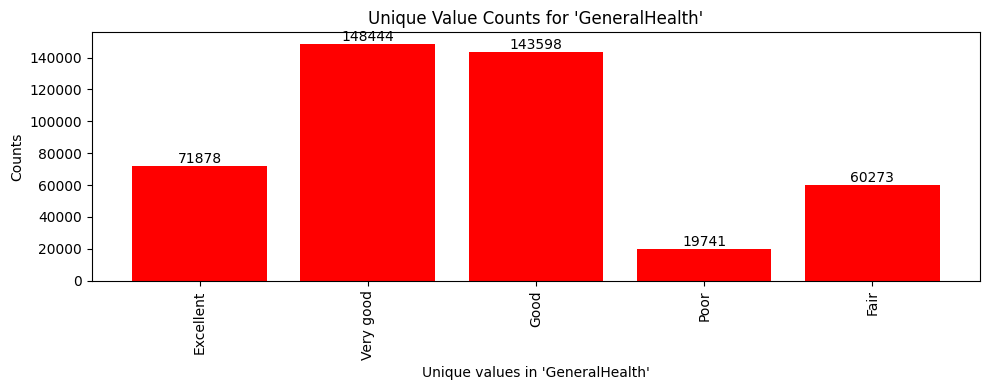

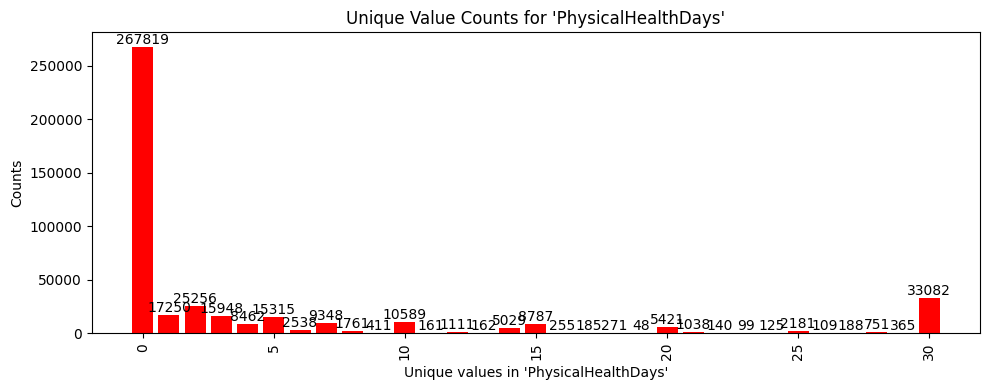

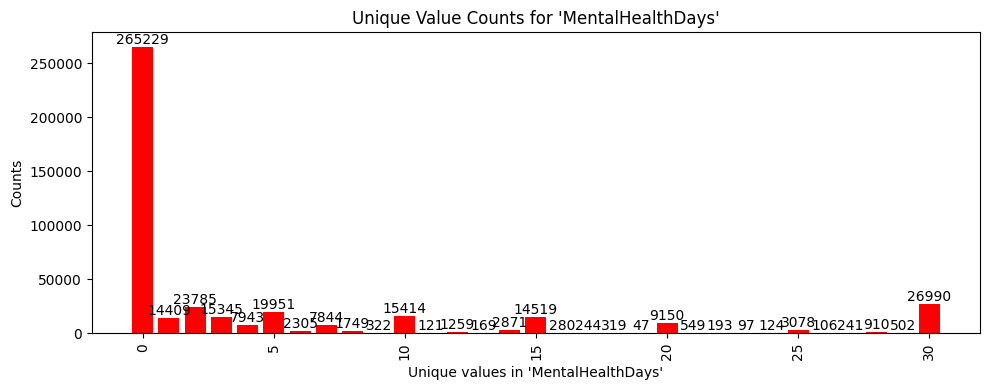

<ipython-input-7-ff93ce3a5b59>:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


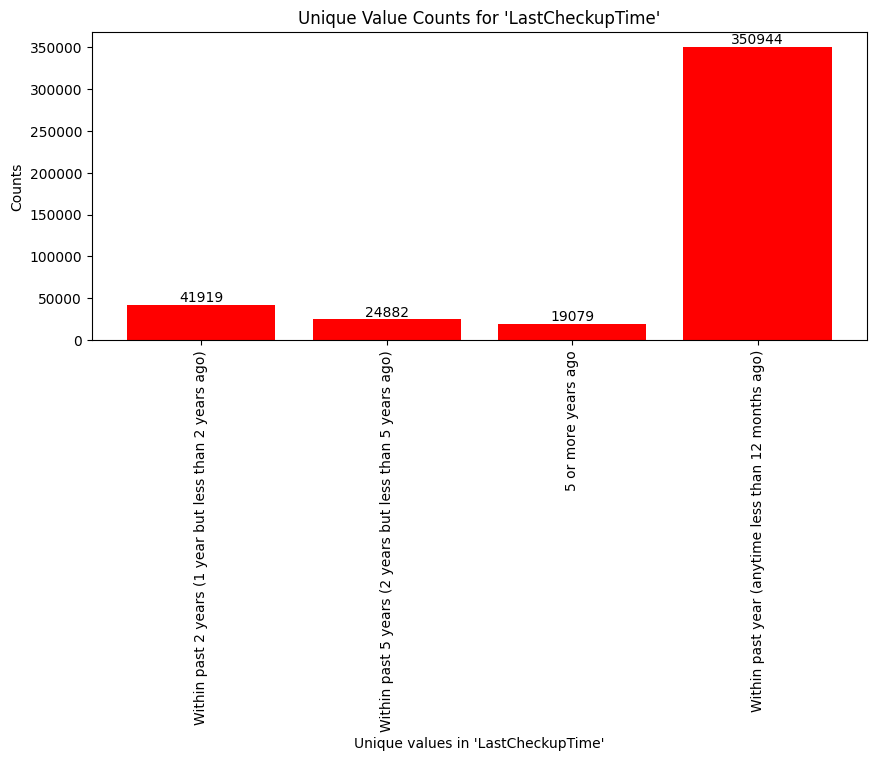

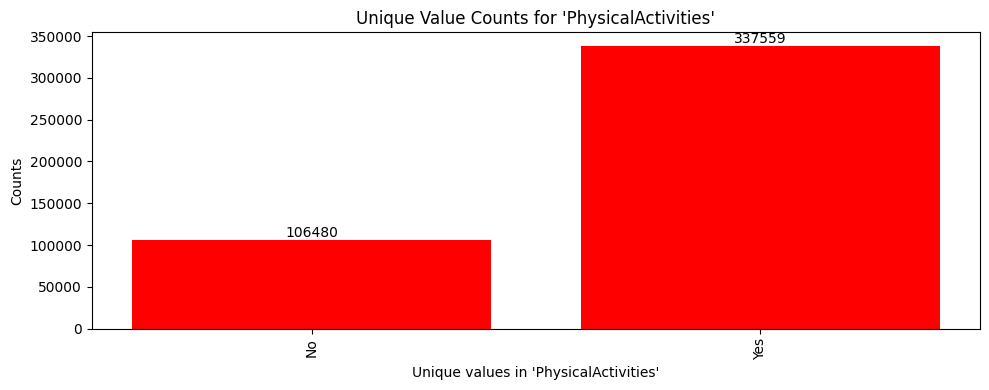

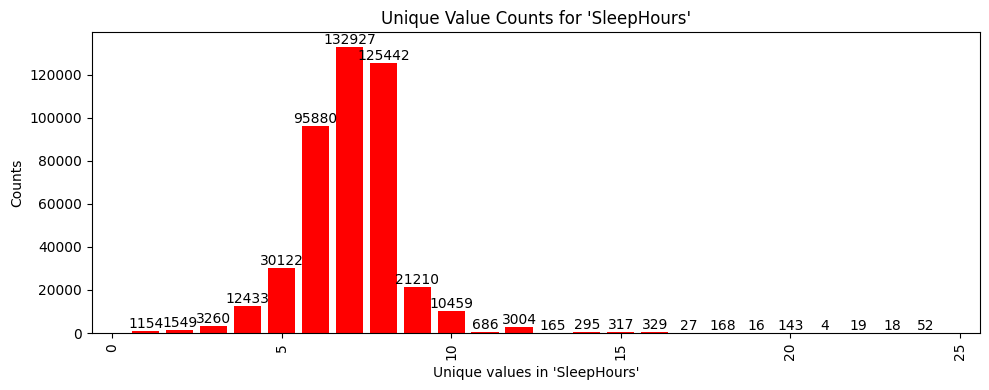

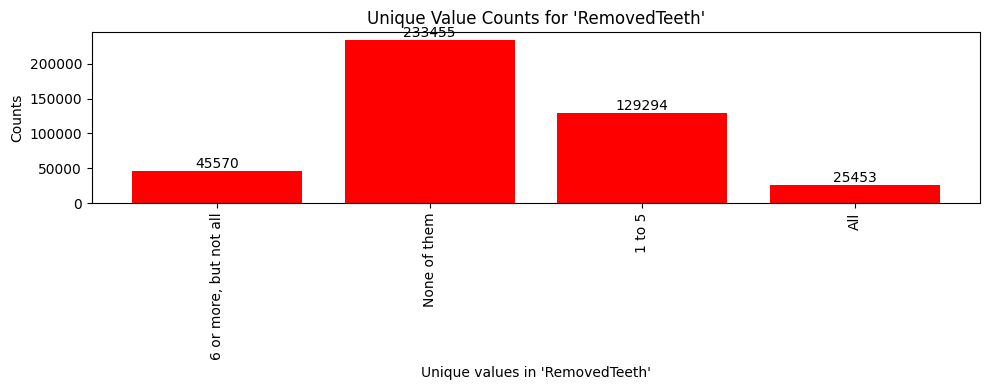

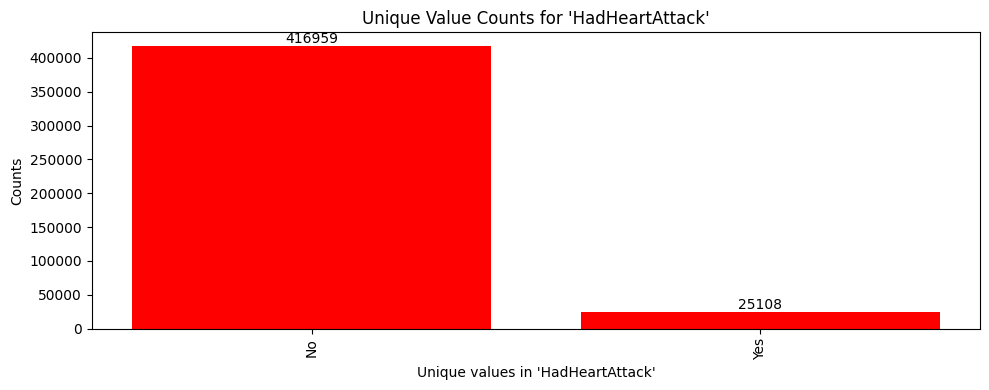

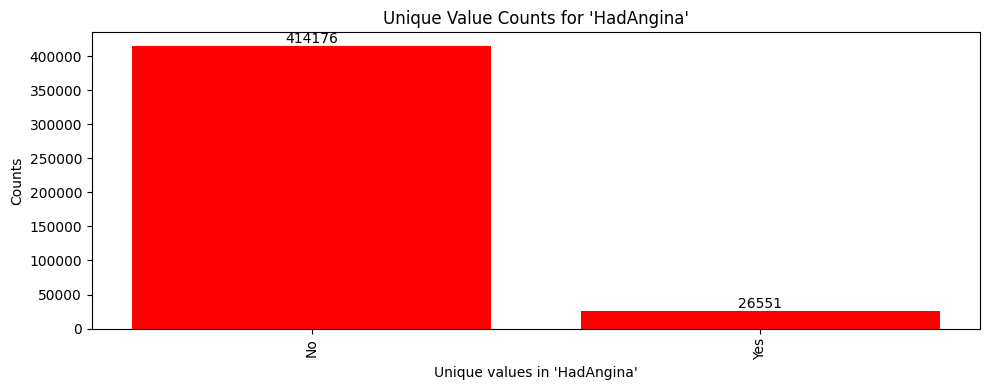

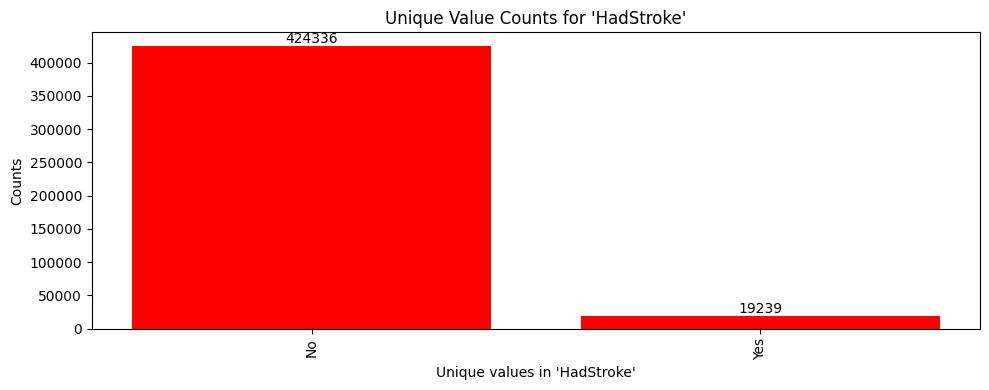

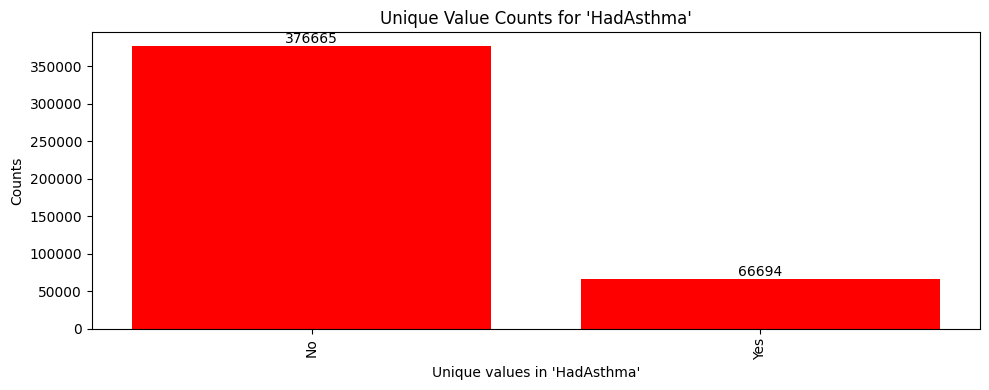

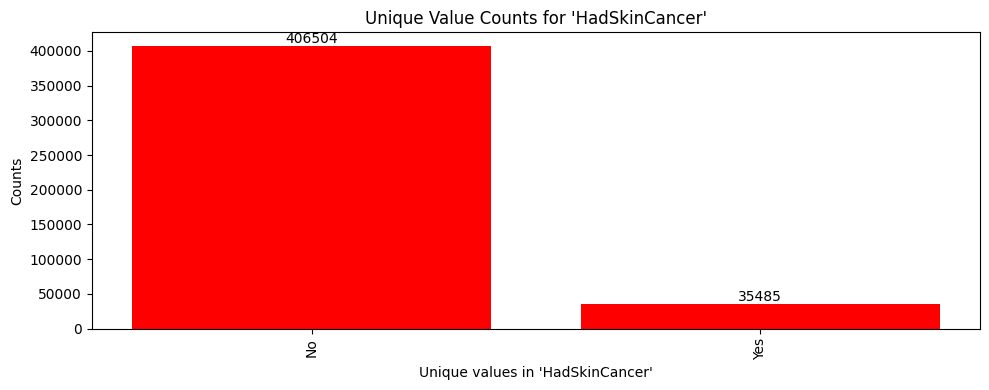

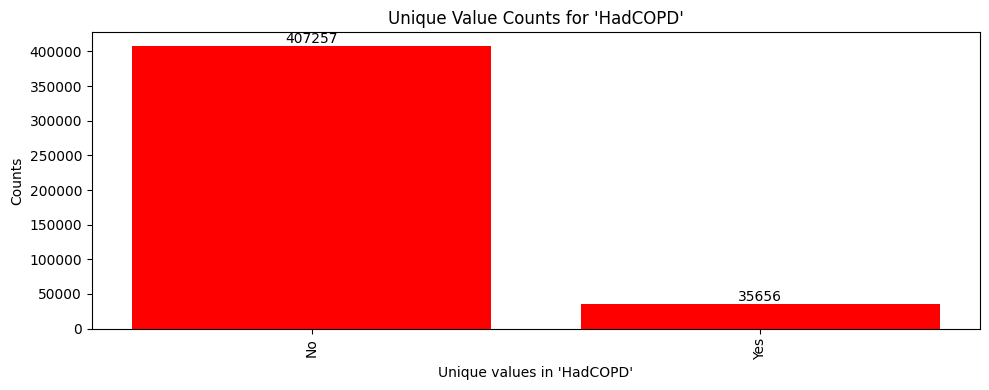

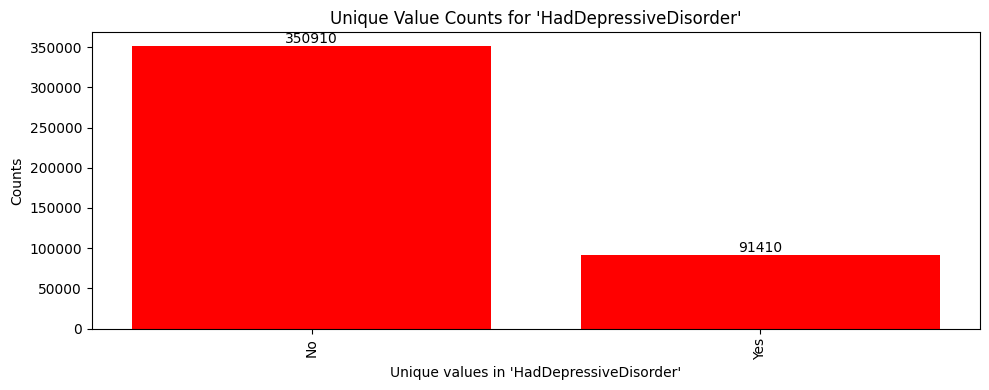

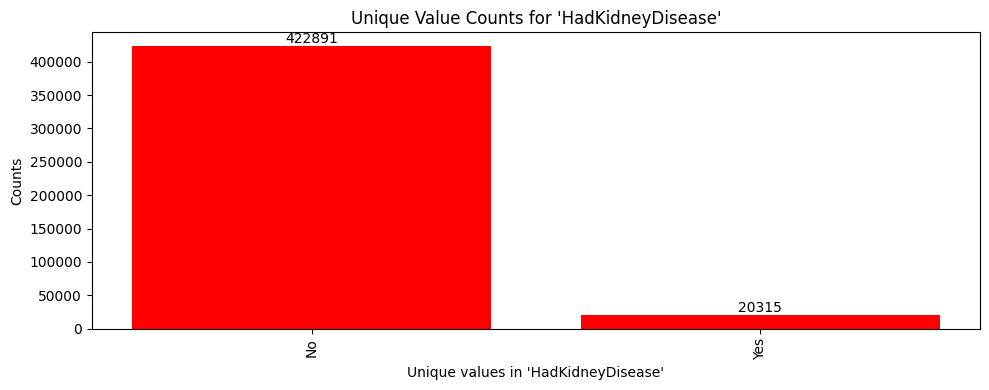

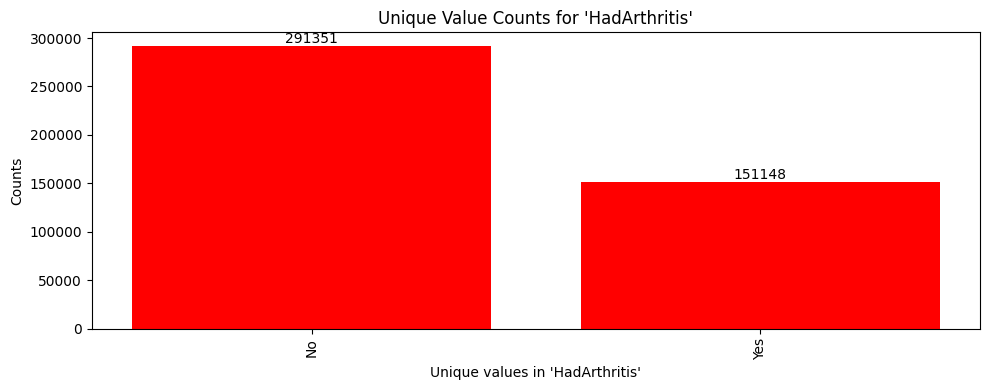

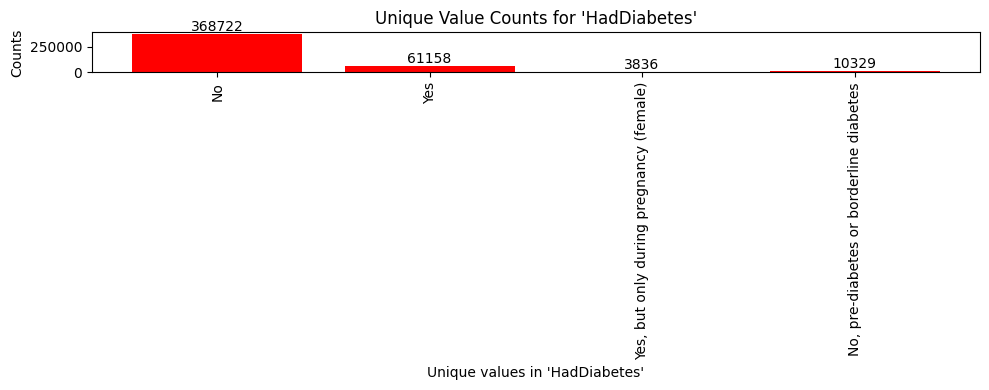

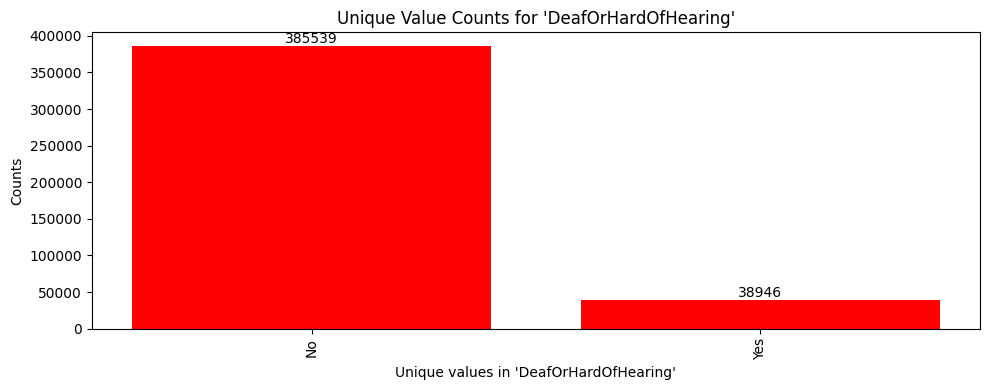

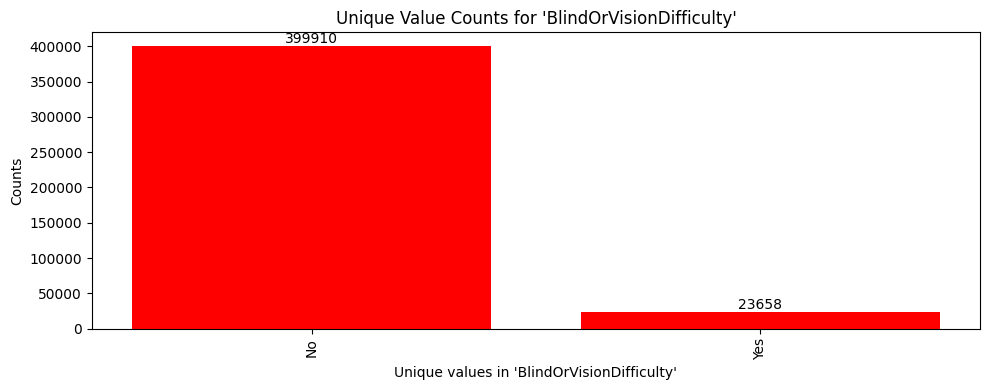

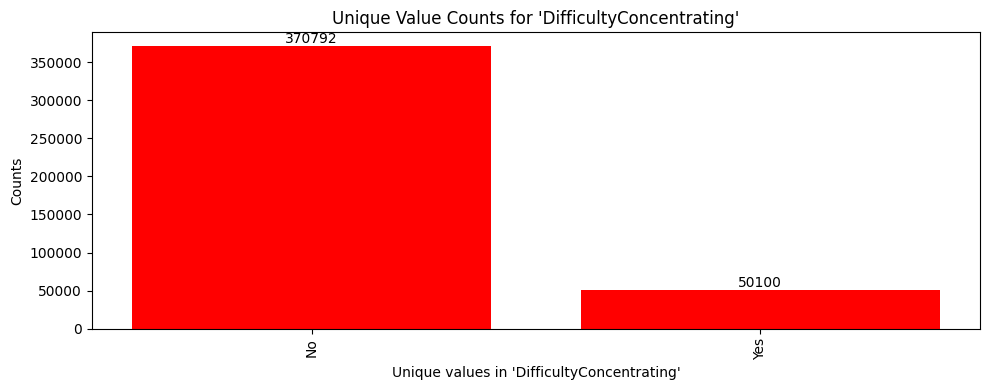

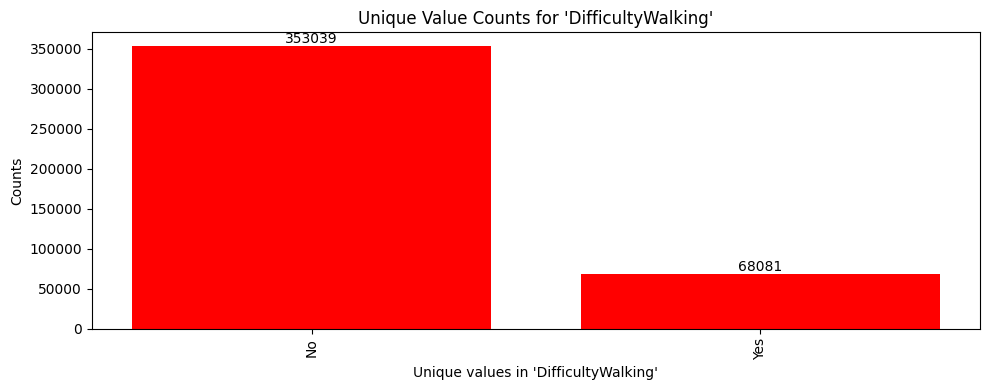

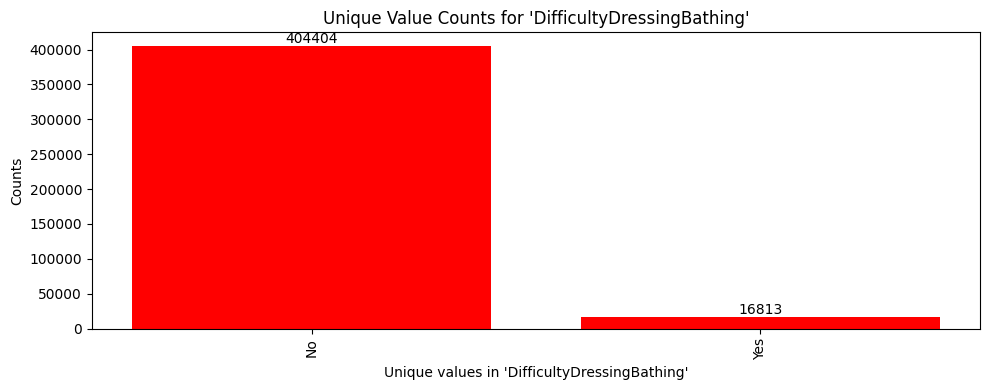

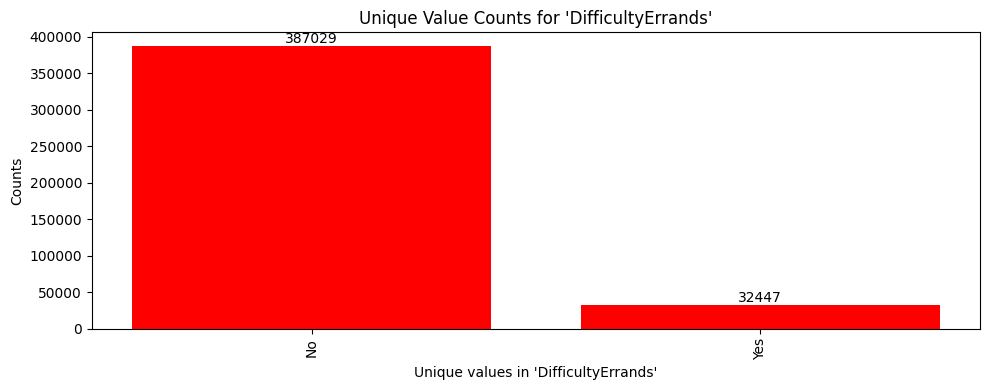

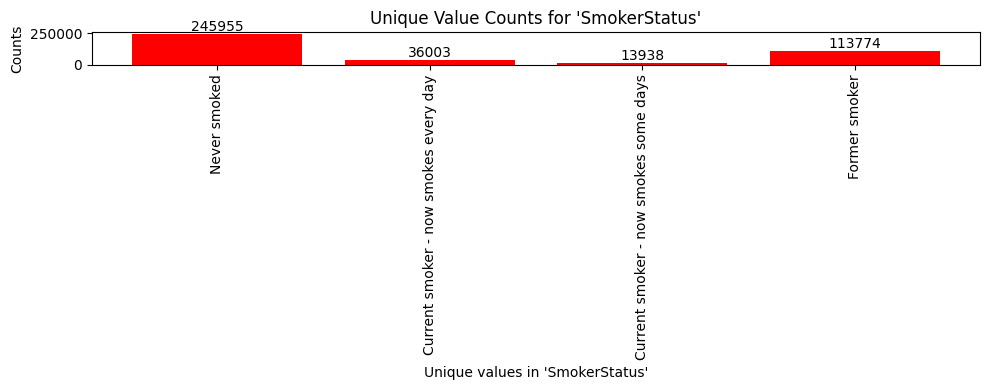

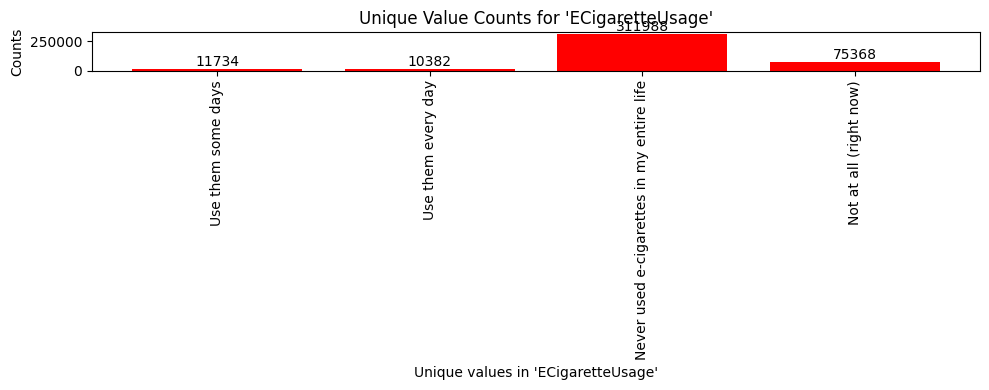

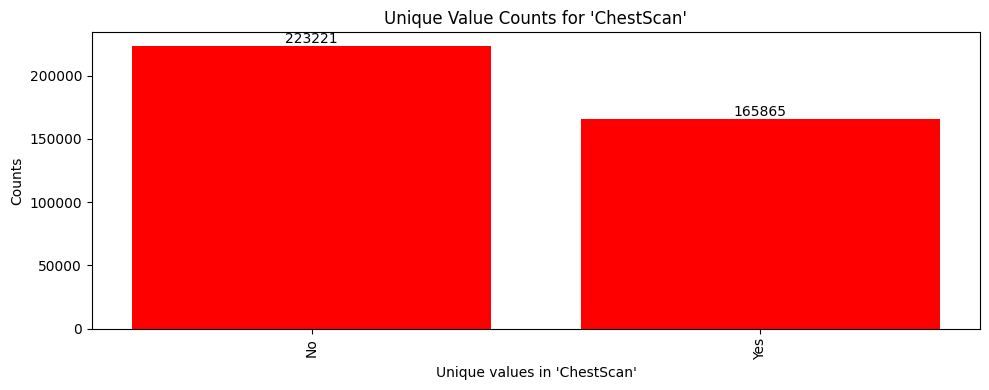

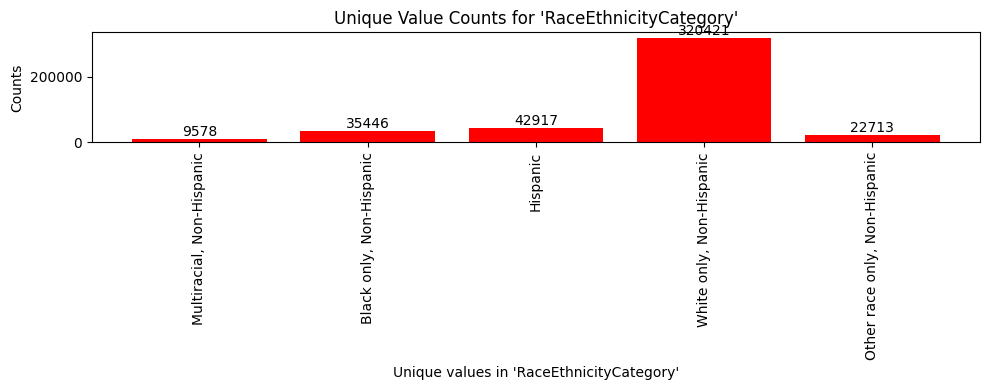

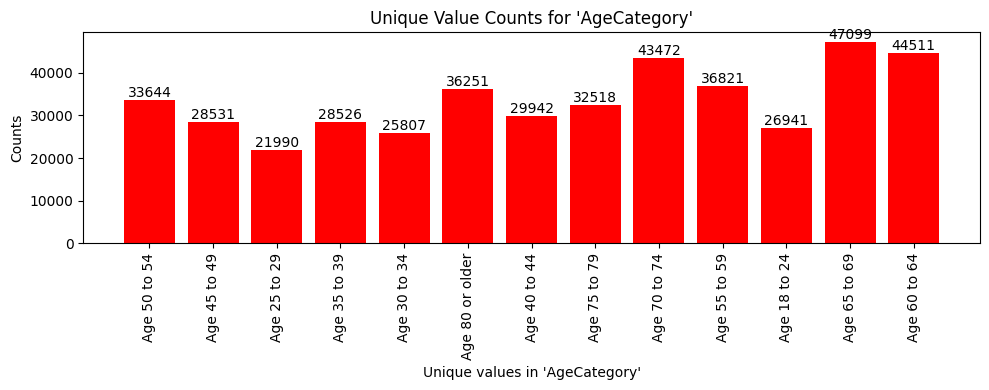

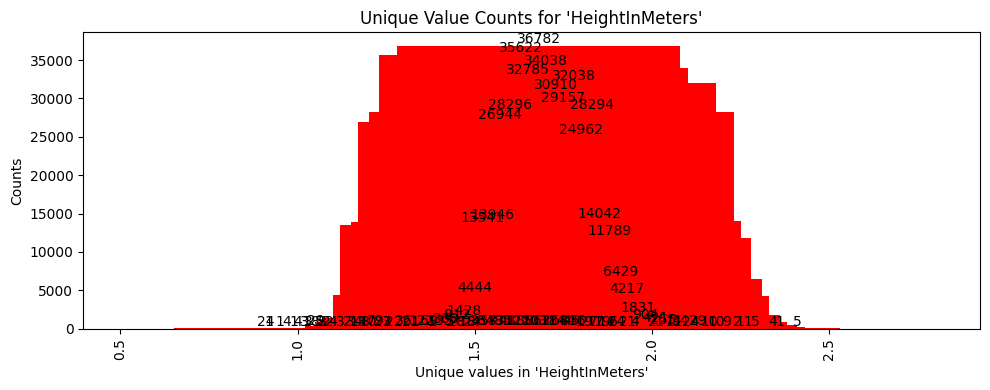

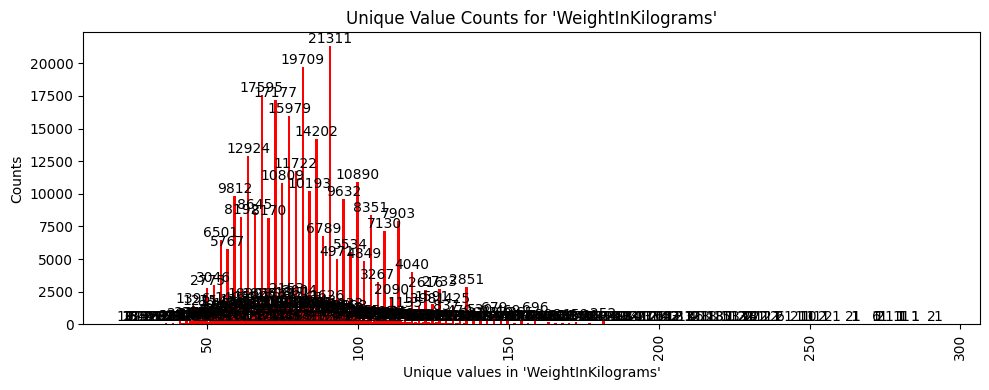

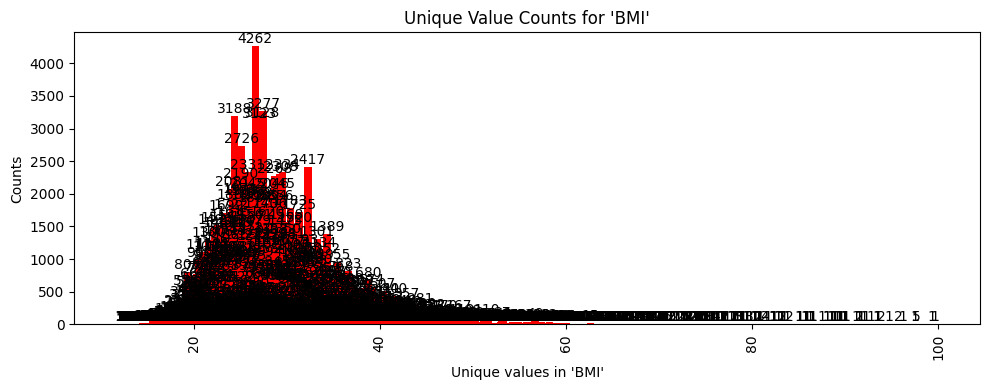

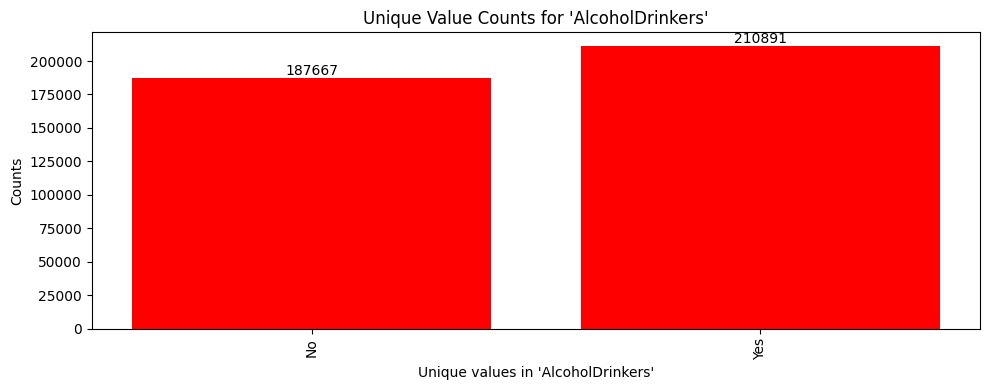

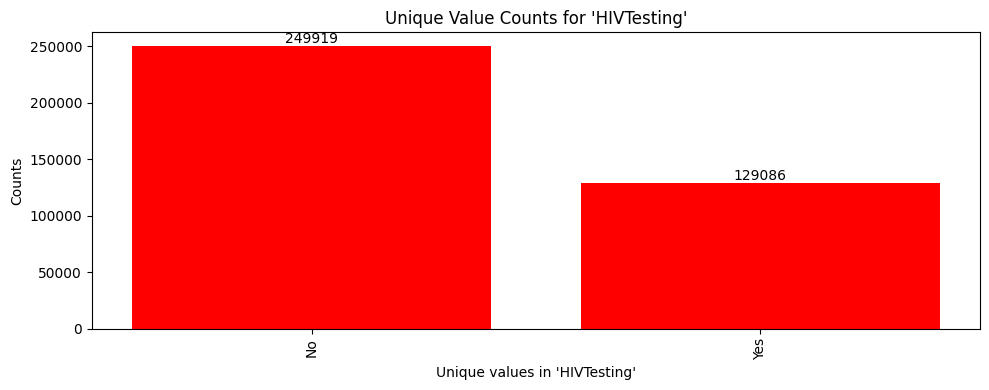

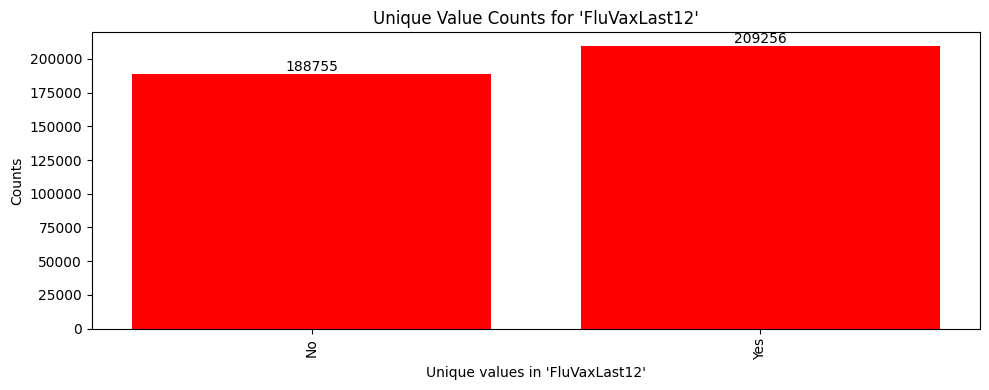

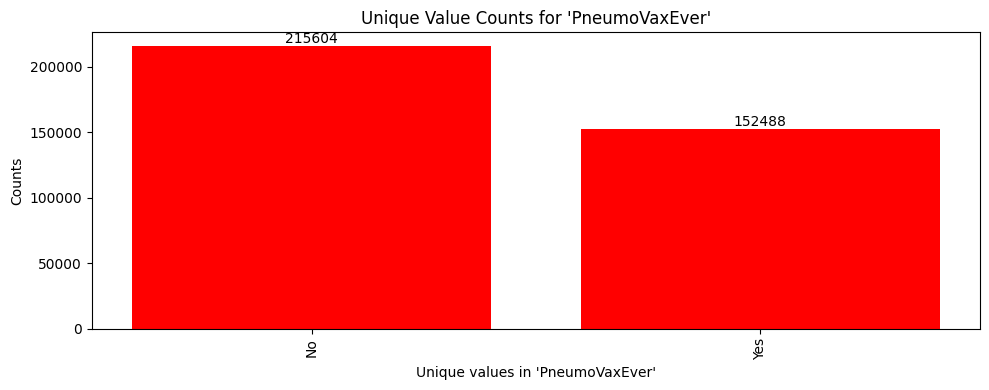

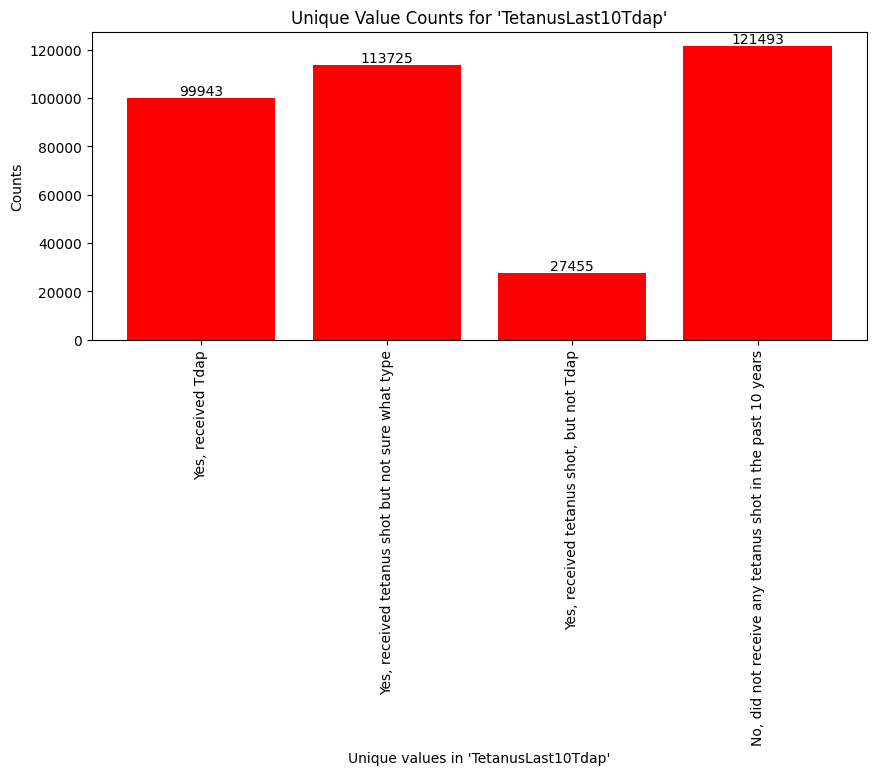

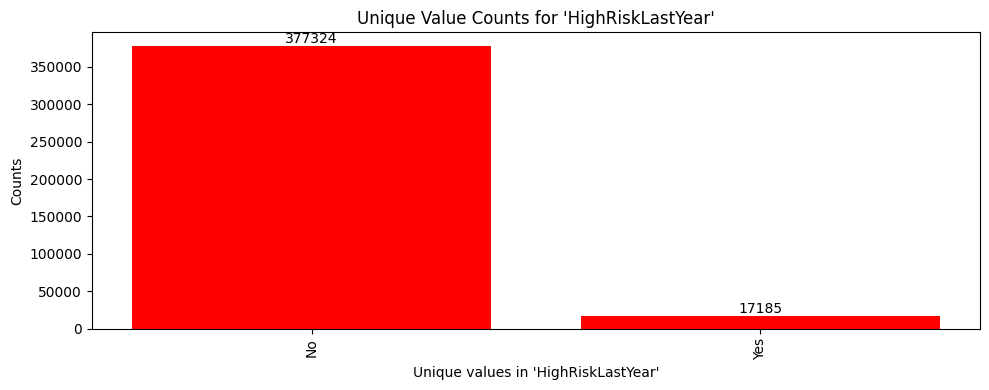

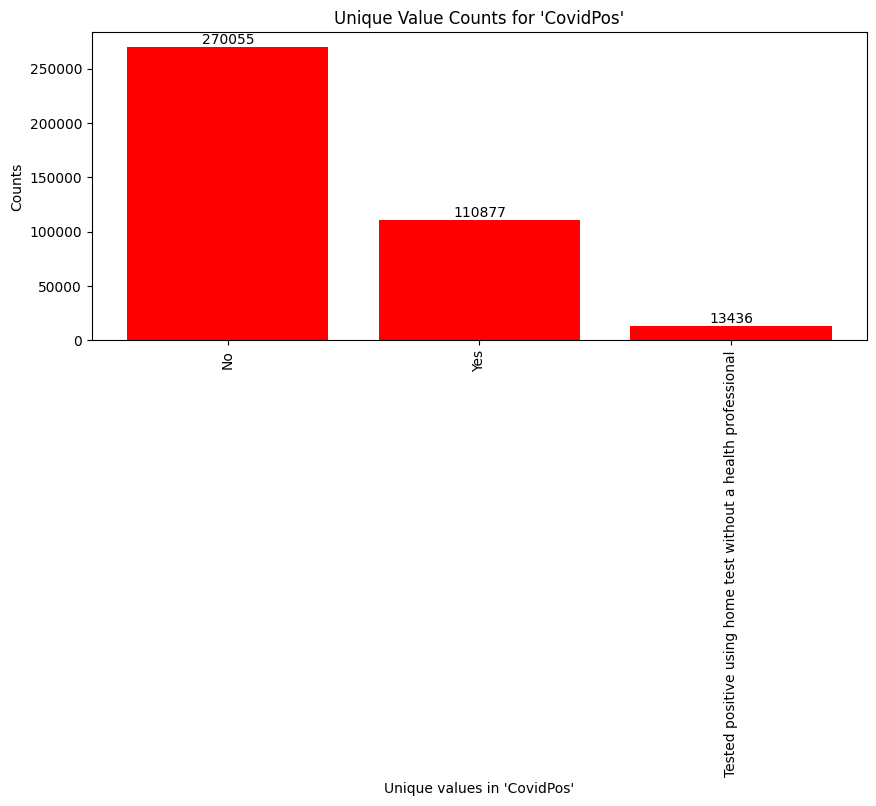

In [ ]:
from pyspark.sql.functions import col, lit

# Loop through each column in the dataset
for column in heart_target.columns:
    # Handle null values dynamically without altering the dataset
    counts_df = heart_target.filter(col(column).isNotNull()).groupBy(column).count()

    counts = counts_df.collect()
    unique_values = [row[column] for row in counts]
    counts_values = [row["count"] for row in counts]

    # Plot
    plt.figure(figsize=(10, 4))
    bars = plt.bar(unique_values, counts_values, color="red")
    plt.xlabel(f"Unique values in '{column}'")
    plt.ylabel("Counts")
    plt.title(f"Unique Value Counts for '{column}'")
    plt.xticks(rotation=90)

    # Add labels on top of the bars
    for bar, count in zip(bars, counts_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 str(count), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    print("\n")

In [ ]:
from pyspark.sql.functions import when, col

# Map "Yes" to 1 and "No" to 0
df = heart_target.withColumn(
    "HadHeartAttack",
    when(col("HadHeartAttack") == "Yes", 1).otherwise(0)
)

In [ ]:
from pyspark.sql.functions import sum

# Aggregate the number of heart attacks by state
state_heart_attack_counts = df.groupBy("State").agg(
    sum("HadHeartAttack").alias("HeartAttackCount")
)

state_heart_attack_counts.show(n=state_heart_attack_counts.count())

+--------------------+----------------+
|               State|HeartAttackCount|
+--------------------+----------------+
|            Arkansas|             454|
|             Alabama|             312|
|             Arizona|             708|
|         Connecticut|             443|
|          California|             443|
|            Delaware|             206|
|              Alaska|             318|
|            Colorado|             371|
|              Hawaii|             322|
|             Georgia|             564|
|                Iowa|             450|
|             Florida|            1018|
|             Indiana|             651|
|            Illinois|             166|
|               Idaho|             326|
|District of Columbia|             111|
|              Kansas|             640|
|            Maryland|             878|
|       Massachusetts|             508|
|            Kentucky|             289|
|           Louisiana|             344|
|               Maine|             750|


In [ ]:
pandas_df = state_heart_attack_counts.toPandas()

import plotly.express as px

# Map full state names to abbreviations
state_abbreviations = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA",
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH",
    "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC",
    "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA",
    "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN",
    "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# Replace full names with abbreviations
pandas_df["State"] = pandas_df["State"].map(state_abbreviations)


fig = px.choropleth(
    pandas_df,
    locations="State",
    locationmode="USA-states",
    color="HeartAttackCount",
    scope="usa",
    title="Number of Heart Attacks per State"
)

fig.show()


In [ ]:
from pyspark.sql.functions import col, sum

missing_count = {column: heart_target.filter(col(column).isNull()).count() for column in heart_target.columns}

print("Missing Values Schema:")
for column, count in missing_count.items():
    print(f" |-- {column}: {count} missing values")

Missing Values Schema:
 |-- State: 0 missing values
 |-- Sex: 0 missing values
 |-- GeneralHealth: 1198 missing values
 |-- PhysicalHealthDays: 10927 missing values
 |-- MentalHealthDays: 9067 missing values
 |-- LastCheckupTime: 8308 missing values
 |-- PhysicalActivities: 1093 missing values
 |-- SleepHours: 5453 missing values
 |-- RemovedTeeth: 11360 missing values
 |-- HadHeartAttack: 3065 missing values
 |-- HadAngina: 4405 missing values
 |-- HadStroke: 1557 missing values
 |-- HadAsthma: 1773 missing values
 |-- HadSkinCancer: 3143 missing values
 |-- HadCOPD: 2219 missing values
 |-- HadDepressiveDisorder: 2812 missing values
 |-- HadKidneyDisease: 1926 missing values
 |-- HadArthritis: 2633 missing values
 |-- HadDiabetes: 1087 missing values
 |-- DeafOrHardOfHearing: 20647 missing values
 |-- BlindOrVisionDifficulty: 21564 missing values
 |-- DifficultyConcentrating: 24240 missing values
 |-- DifficultyWalking: 24012 missing values
 |-- DifficultyDressingBathing: 23915 missi

In [ ]:
heart_temp = spark.read.csv('/content/drive/MyDrive/datasets_final/LLCP2021.csv', header=True, inferSchema=True)

In [ ]:
# Get the number of rows
num_rows = heart_temp.count()

# Get the number of columns
num_columns = len(heart_temp.columns)

# Print the shape
print((num_rows, num_columns))

(438693, 303)


# Pre-processing


Goals:


*   Rename columns according to the target dataframe
*   Fill in missing values
*   Encode




In [ ]:
heart_target=heart_target.drop("SleepHours", "RemovedTeeth", "HighRiskLastYear", "CovidPos")
print(len(heart_target.columns))

36


In [ ]:
heart_target.printSchema()

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = true)
 |-- DifficultyWalking: string (nullable = true)
 |-- DifficultyDressingBathing: 

## 2021 Dataset to adjust to fill missing values

Code borowed from https://github.com/kamilpytlak/data-science-projects/blob/main/heart-disease-prediction/2022/notebooks/data_processing.ipynb

In [ ]:
NEW_VAR_NAMES = [
    "State",
    "Sex",
    "GeneralHealth",
    "PhysicalHealthDays",
    "MentalHealthDays",
    "LastCheckupTime",
    "PhysicalActivities",
    "HadHeartAttack",
    "HadAngina",
    "HadStroke",
    "HadAsthma",
    "HadSkinCancer",
    "HadCOPD",
    "HadDepressiveDisorder",
    "HadKidneyDisease",
    "HadArthritis",
    "HadDiabetes",
    "DeafOrHardOfHearing",
    "BlindOrVisionDifficulty",
    "DifficultyConcentrating",
    "DifficultyWalking",
    "DifficultyDressingBathing",
    "DifficultyErrands",
    "SmokerStatus",
    "ECigaretteUsage",
    "ChestScan",
    "RaceEthnicityCategory",
    "AgeCategory",
    "HeightInMeters",
    "WeightInKilograms",
    "BMI",
    "AlcoholDrinkers",
    "HIVTesting",
    "FluVaxLast12",
    "PneumoVaxEver",
    "TetanusLast10Tdap",
]

In [ ]:
columns = [
    '_STATE', 'SEXVAR', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'CHECKUP1',
    'EXERANY2', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3',
    'CHCSCNCR', 'CHCCOPD3', 'ADDEPEV3','CHCKDNY2', 'HAVARTH5',
    'DIABETE4', 'DEAF', 'BLIND', 'DECIDE','DIFFWALK', 'DIFFDRES',
    'DIFFALON', '_SMOKER3', 'ECIGNOW1','LCSCTSCN', '_RACEGR3',
    '_AGEG5YR', 'HTM4', 'WTKG3', '_BMI5','DRNKANY5',
    '_AIDTST4', 'FLUSHOT7', 'PNEUVAC4', 'TETANUS1',
]

In [ ]:
existing_columns = heart_temp.columns

# Check for missing columns
missing_columns = [col for col in columns if col not in existing_columns]

if not missing_columns:
    print("All columns are present in heart_temp.")
else:
    print("The following columns are missing:", missing_columns)

All columns are present in heart_temp.


In [ ]:
filtered_columns = [col for col in columns if col in heart_temp.columns]
heart_temp = heart_temp.select(*filtered_columns)

heart_temp.printSchema()

root
 |-- _STATE: integer (nullable = true)
 |-- SEXVAR: integer (nullable = true)
 |-- GENHLTH: integer (nullable = true)
 |-- PHYSHLTH: integer (nullable = true)
 |-- MENTHLTH: integer (nullable = true)
 |-- CHECKUP1: integer (nullable = true)
 |-- EXERANY2: integer (nullable = true)
 |-- CVDINFR4: integer (nullable = true)
 |-- CVDCRHD4: integer (nullable = true)
 |-- CVDSTRK3: integer (nullable = true)
 |-- ASTHMA3: integer (nullable = true)
 |-- CHCSCNCR: integer (nullable = true)
 |-- CHCCOPD3: integer (nullable = true)
 |-- ADDEPEV3: integer (nullable = true)
 |-- CHCKDNY2: integer (nullable = true)
 |-- HAVARTH5: integer (nullable = true)
 |-- DIABETE4: integer (nullable = true)
 |-- DEAF: integer (nullable = true)
 |-- BLIND: integer (nullable = true)
 |-- DECIDE: integer (nullable = true)
 |-- DIFFWALK: integer (nullable = true)
 |-- DIFFDRES: integer (nullable = true)
 |-- DIFFALON: integer (nullable = true)
 |-- _SMOKER3: integer (nullable = true)
 |-- ECIGNOW1: integer (nu

In [ ]:
heart_temp = heart_temp.toDF(*NEW_VAR_NAMES)
heart_temp.printSchema()

root
 |-- State: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- GeneralHealth: integer (nullable = true)
 |-- PhysicalHealthDays: integer (nullable = true)
 |-- MentalHealthDays: integer (nullable = true)
 |-- LastCheckupTime: integer (nullable = true)
 |-- PhysicalActivities: integer (nullable = true)
 |-- HadHeartAttack: integer (nullable = true)
 |-- HadAngina: integer (nullable = true)
 |-- HadStroke: integer (nullable = true)
 |-- HadAsthma: integer (nullable = true)
 |-- HadSkinCancer: integer (nullable = true)
 |-- HadCOPD: integer (nullable = true)
 |-- HadDepressiveDisorder: integer (nullable = true)
 |-- HadKidneyDisease: integer (nullable = true)
 |-- HadArthritis: integer (nullable = true)
 |-- HadDiabetes: integer (nullable = true)
 |-- DeafOrHardOfHearing: integer (nullable = true)
 |-- BlindOrVisionDifficulty: integer (nullable = true)
 |-- DifficultyConcentrating: integer (nullable = true)
 |-- DifficultyWalking: integer (nullable = true)
 |-- Diffic

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import numpy as np

# mapping
STATE = {1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
         8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia", 12: "Florida",
         13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois", 18: "Indiana", 19: "Iowa",
         20: "Kansas", 21: "Kentucky", 22: "Louisiana", 23: "Maine", 24: "Maryland",
         25: "Massachusetts", 26: "Michigan", 27: "Minnesota", 28: "Mississippi", 29: "Missouri",
         30: "Montana", 31: "Nebraska", 32: "Nevada", 33: "New Hampshire", 34: "New Jersey",
         35: "New Mexico", 36: "New York", 37: "North Carolina", 38: "North Dakota", 39: "Ohio",
         40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania", 44: "Rhode Island", 45: "South Carolina",
         46: "South Dakota", 47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont",
         51: "Virginia", 53: "Washington", 54: "West Virginia", 55: "Wisconsin", 56: "Wyoming",
         66: "Guam", 72: "Puerto Rico", 78: "Virgin Islands"}

SEX = {1: 'Male', 2: 'Female'}

GEN_HEALTH = {1: "Excellent", 2: "Very good", 3: "Good", 4: "Fair", 5: "Poor"}

PHYS_MEN_HEALTH = {77: -1, 88: 0, 99: -1}

LAST_CHECKUP = {
    1: "Within past year (anytime less than 12 months ago)",
    2: "Within past 2 years (1 year but less than 2 years ago)",
    3: "Within past 5 years (2 years but less than 5 years ago)",
    4: "5 or more years ago"
}

YES_NO_QUESTIONS = {1: 'Yes', 2: 'No'}

DIABETES = {
    1: "Yes",
    2: "Yes, but only during pregnancy (female)",
    3: "No",
    4: "No, pre-diabetes or borderline diabetes",
}

SMOKER_STATUS = {
    1: "Current smoker - now smokes every day",
    2: "Current smoker - now smokes some days",
    3: "Former smoker",
    4: "Never smoked"
}

ECIGARETTES = {
    1: "Never used e-cigarettes in my entire life",
    2: "Use them every day",
    3: "Use them some days",
    4: "Not at all (right now)"
}

RACE = {
    1: "White only, Non-Hispanic",
    2: "Black only, Non-Hispanic",
    3: "Other race only, Non-Hispanic",
    4: "Multiracial, Non-Hispanic",
    5: "Hispanic"
}

AGE_CATEGORY = {
    1: "Age 18 to 24",
    2: "Age 25 to 29",
    3: "Age 30 to 34",
    4: "Age 35 to 39",
    5: "Age 40 to 44",
    6: "Age 45 to 49",
    7: "Age 50 to 54",
    8: "Age 55 to 59",
    9: "Age 60 to 64",
    10: "Age 65 to 69",
    11: "Age 70 to 74",
    12: "Age 75 to 79",
    13: "Age 80 or older"
}

TETANUS = {
    1: "Yes, received Tdap",
    2: "Yes, received tetanus shot, but not Tdap",
    3: "Yes, received tetanus shot but not sure what type",
    4: "No, did not receive any tetanus shot in the past 10 years",
}

# Convert each dictionary to broadcast variables
broadcasted_maps = {
    "STATE": spark.sparkContext.broadcast(STATE),
    "SEX": spark.sparkContext.broadcast(SEX),
    "GEN_HEALTH": spark.sparkContext.broadcast(GEN_HEALTH),
    "PHYS_MEN_HEALTH": spark.sparkContext.broadcast(PHYS_MEN_HEALTH),
    "LAST_CHECKUP": spark.sparkContext.broadcast(LAST_CHECKUP),
    "YES_NO_QUESTIONS": spark.sparkContext.broadcast(YES_NO_QUESTIONS),
    "DIABETES": spark.sparkContext.broadcast(DIABETES),
    "SMOKER_STATUS": spark.sparkContext.broadcast(SMOKER_STATUS),
    "ECIGARETTES": spark.sparkContext.broadcast(ECIGARETTES),
    "RACE": spark.sparkContext.broadcast(RACE),
    "AGE_CATEGORY": spark.sparkContext.broadcast(AGE_CATEGORY),
    "TETANUS": spark.sparkContext.broadcast(TETANUS)
}

# UDF to map values
def map_lookup(value, map_name):
    mapping = broadcasted_maps[map_name].value
    return mapping.get(value, None)

map_udf = udf(lambda value, map_name: map_lookup(value, map_name), StringType())

In [ ]:
heart_temp_copy = heart_temp

In [ ]:
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql.functions import col, lit

# Transform columns with correct types
heart_temp_copy = heart_temp_copy.withColumn("State", udf(lambda x: map_lookup(x, "STATE"), StringType())(col("State")))
heart_temp_copy = heart_temp_copy.withColumn("Sex", udf(lambda x: map_lookup(x, "SEX"), StringType())(col("Sex")))
heart_temp_copy = heart_temp_copy.withColumn("GeneralHealth", udf(lambda x: map_lookup(x, "GEN_HEALTH"), StringType())(col("GeneralHealth")))
heart_temp_copy = heart_temp_copy.withColumn("LastCheckupTime", udf(lambda x: map_lookup(x, "LAST_CHECKUP"), StringType())(col("LastCheckupTime")))

# Apply UDF for Yes/No questions
yes_no_columns = [
    "PhysicalActivities", "HadHeartAttack", "HadAngina", "HadStroke", "HadAsthma", "HadSkinCancer",
    "HadCOPD", "HadDepressiveDisorder", "HadKidneyDisease", "HadArthritis", "DeafOrHardOfHearing",
    "BlindOrVisionDifficulty", "DifficultyConcentrating", "DifficultyWalking",
    "DifficultyDressingBathing", "DifficultyErrands", "ChestScan", "AlcoholDrinkers",
    "HIVTesting", "FluVaxLast12", "PneumoVaxEver"
]

for col_name in yes_no_columns:
    heart_temp_copy = heart_temp_copy.withColumn(col_name, udf(lambda x: map_lookup(x, "YES_NO_QUESTIONS"), StringType())(col(col_name)))

# Additional transformations
heart_temp_copy = heart_temp_copy.withColumn("HadDiabetes", udf(lambda x: map_lookup(x, "DIABETES"), StringType())(col("HadDiabetes")))
heart_temp_copy = heart_temp_copy.withColumn("SmokerStatus", udf(lambda x: map_lookup(x, "SMOKER_STATUS"), StringType())(col("SmokerStatus")))
heart_temp_copy = heart_temp_copy.withColumn("ECigaretteUsage", udf(lambda x: map_lookup(x, "ECIGARETTES"), StringType())(col("ECigaretteUsage")))
heart_temp_copy = heart_temp_copy.withColumn("RaceEthnicityCategory", udf(lambda x: map_lookup(x, "RACE"), StringType())(col("RaceEthnicityCategory")))
heart_temp_copy = heart_temp_copy.withColumn("AgeCategory", udf(lambda x: map_lookup(x, "AGE_CATEGORY"), StringType())(col("AgeCategory")))
heart_temp_copy = heart_temp_copy.withColumn("TetanusLast10Tdap", udf(lambda x: map_lookup(x, "TETANUS"), StringType())(col("TetanusLast10Tdap")))

# Convert height, weight, and BMI to meters and kilograms
heart_temp_copy = heart_temp_copy.withColumn("HeightInMeters", (col("HeightInMeters") / 100).cast(DoubleType()))
heart_temp_copy = heart_temp_copy.withColumn("WeightInKilograms", (col("WeightInKilograms") / 100).cast(DoubleType()))
heart_temp_copy = heart_temp_copy.withColumn("BMI", (col("BMI") / 100).cast(DoubleType()))

# Show the transformed DataFrame
heart_temp_copy.show()

+-------+------+-------------+------------------+----------------+--------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+-----------------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBathing|DifficultyErrands|        SmokerStatus|   ECigaretteUsage|ChestScan|RaceEthnicityCat

In [ ]:
# Get the number of rows
num_rows = heart_temp_copy.count()

# Get the number of columns
num_columns = len(heart_temp_copy.columns)

# Print the shape
print((num_rows, num_columns))

(438693, 36)


In [ ]:
# Map "Yes" to 1 and "No" to 0
df = heart_temp_copy.withColumn(
    "HadHeartAttack",
    when(col("HadHeartAttack") == "Yes", 1).otherwise(0)
)

# Aggregate the number of heart attacks by state
state_heart_attack_counts = df.groupBy("State").agg(
    sum("HadHeartAttack").alias("HeartAttackCount")
)

# Show results
state_heart_attack_counts.show(n=state_heart_attack_counts.count(), truncate=False)

+--------------------+----------------+
|State               |HeartAttackCount|
+--------------------+----------------+
|Arkansas            |462             |
|Alabama             |284             |
|Arizona             |583             |
|Connecticut         |309             |
|District of Columbia|105             |
|California          |242             |
|Delaware            |185             |
|Alaska              |251             |
|Colorado            |350             |
|Hawaii              |286             |
|Georgia             |487             |
|Kansas              |933             |
|Iowa                |470             |
|Indiana             |564             |
|Illinois            |126             |
|Idaho               |347             |
|Maryland            |712             |
|Massachusetts       |296             |
|Kentucky            |371             |
|Louisiana           |299             |
|Maine               |778             |
|Minnesota           |677             |


In [ ]:
heart_temp_copy = heart_temp_copy.filter(heart_temp_copy["State"].isin("New York"))
heart_target = heart_target.filter(heart_target["State"].isin("New York"))

In [ ]:
# Map "Yes" to 1 and "No" to 0
df = heart_temp_copy.withColumn(
    "HadHeartAttack",
    when(col("HadHeartAttack") == "Yes", 1).otherwise(0)
)

In [ ]:
# Aggregate the number of heart attacks by state
state_heart_attack_counts = df.groupBy("State").agg(
    sum("HadHeartAttack").alias("HeartAttackCount")
)

# Show results
state_heart_attack_counts.show()

+--------+----------------+
|   State|HeartAttackCount|
+--------+----------------+
|New York|            2105|
+--------+----------------+



In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import DataFrame

# Filter rows with 'Yes' in the HadHeartAttack column
yes_heart_attack_rows = heart_temp_copy.filter(col("HadHeartAttack") == "Yes")

# Filter rows with values other than 'Yes' in the HadHeartAttack column
other_rows = heart_temp_copy.filter(col("HadHeartAttack") != "Yes")

# Randomly sample 2000 rows from the other rows
random_sample = other_rows.sample(withReplacement=False, fraction=2000 / other_rows.count())

# Union the 'Yes' rows and the random sample
heart_temp_copy = yes_heart_attack_rows.union(random_sample)

heart_temp_copy.show(5, truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------------------------------+------------------+---------+------------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+-----------------+
|State   |Sex   |GeneralHealth|PhysicalHealthDays|MentalHealthDays|LastCheckupTime                                   |PhysicalActivities|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBathing|Di

In [ ]:
# Get the number of rows
num_rows = heart_temp_copy.count()

# Get the number of columns
num_columns = len(heart_temp_copy.columns)

# Print the shape
print((num_rows, num_columns))

(4087, 36)


In [ ]:
missing_count2 = {column: heart_temp_copy.filter(col(column).isNull()).count() for column in heart_temp_copy.columns}

print("Missing Values Schema:")
for column, count in missing_count2.items():
    print(f" |-- {column}: {count} missing values")

Missing Values Schema:
 |-- State: 0 missing values
 |-- Sex: 0 missing values
 |-- GeneralHealth: 19 missing values
 |-- PhysicalHealthDays: 0 missing values
 |-- MentalHealthDays: 0 missing values
 |-- LastCheckupTime: 73 missing values
 |-- PhysicalActivities: 21 missing values
 |-- HadHeartAttack: 0 missing values
 |-- HadAngina: 113 missing values
 |-- HadStroke: 29 missing values
 |-- HadAsthma: 17 missing values
 |-- HadSkinCancer: 20 missing values
 |-- HadCOPD: 30 missing values
 |-- HadDepressiveDisorder: 27 missing values
 |-- HadKidneyDisease: 44 missing values
 |-- HadArthritis: 22 missing values
 |-- HadDiabetes: 9 missing values
 |-- DeafOrHardOfHearing: 191 missing values
 |-- BlindOrVisionDifficulty: 208 missing values
 |-- DifficultyConcentrating: 230 missing values
 |-- DifficultyWalking: 230 missing values
 |-- DifficultyDressingBathing: 232 missing values
 |-- DifficultyErrands: 245 missing values
 |-- SmokerStatus: 285 missing values
 |-- ECigaretteUsage: 276 miss

In [ ]:
heart_target=heart_target.drop("ChestScan","TetanusLast10Tdap")
heart_temp_copy=heart_temp_copy.drop("ChestScan","TetanusLast10Tdap")

## Deal with np.nan

In [ ]:
from pyspark.sql.functions import when

# Replace 77 and 99 with -1 in 'PhysicalHealthDays' and 'MentalHealthDays'
heart_temp_copy = heart_temp_copy.withColumn(
    "PhysicalHealthDays",
    when((col("PhysicalHealthDays") == 77) | (col("PhysicalHealthDays") == 99), -1).otherwise(col("PhysicalHealthDays"))
)

heart_temp_copy = heart_temp_copy.withColumn(
    "MentalHealthDays",
    when((col("MentalHealthDays") == 77) | (col("MentalHealthDays") == 99), -1).otherwise(col("MentalHealthDays"))
)

heart_target = heart_target.withColumn(
    "PhysicalHealthDays",
    when((col("PhysicalHealthDays") == 77) | (col("PhysicalHealthDays") == 99), -1).otherwise(col("PhysicalHealthDays"))
)

heart_target = heart_target.withColumn(
    "MentalHealthDays",
    when((col("MentalHealthDays") == 77) | (col("MentalHealthDays") == 99), -1).otherwise(col("MentalHealthDays"))
)

## Filling in missing data



*   Fill in missing data of heart_target based on heart_temp_copy


### Filtering

In [ ]:
from pyspark.sql.functions import col, mean, count, desc

# Replace nulls in numeric columns with the column mean
numeric_columns = [col_name for col_name, dtype in heart_temp_copy.dtypes if dtype in ('int', 'double')]
numeric_means = heart_temp_copy.select(
    *[mean(col(col_name)).alias(col_name) for col_name in numeric_columns]
).collect()[0]

# Create a dictionary for numeric column replacements
numeric_fill_dict = {col_name: numeric_means[col_name] for col_name in numeric_columns if numeric_means[col_name] is not None}
heart_temp_copy = heart_temp_copy.fillna(numeric_fill_dict)

# Replace nulls in categorical columns with the mode
categorical_columns = [col_name for col_name, dtype in heart_temp_copy.dtypes if dtype == 'string']
categorical_fill_dict = {}

for col_name in categorical_columns:
    mode_row = (
        heart_temp_copy.groupBy(col_name)
        .agg(count(col(col_name)).alias('count'))
        .orderBy(desc('count'))
        .limit(1)
        .collect()
    )
    if mode_row:
        categorical_fill_dict[col_name] = mode_row[0][0]

# Fill nulls for categorical columns
heart_temp_copy = heart_temp_copy.fillna(categorical_fill_dict)

In [ ]:
missing_count = {column: heart_temp_copy.filter(col(column).isNull()).count() for column in heart_temp_copy.columns}

print("Missing Values Schema:")
for column, count in missing_count.items():
    print(f" |-- {column}: {count} missing values")

Missing Values Schema:
 |-- State: 0 missing values
 |-- Sex: 0 missing values
 |-- GeneralHealth: 0 missing values
 |-- PhysicalHealthDays: 0 missing values
 |-- MentalHealthDays: 0 missing values
 |-- LastCheckupTime: 0 missing values
 |-- PhysicalActivities: 0 missing values
 |-- HadHeartAttack: 0 missing values
 |-- HadAngina: 0 missing values
 |-- HadStroke: 0 missing values
 |-- HadAsthma: 0 missing values
 |-- HadSkinCancer: 0 missing values
 |-- HadCOPD: 0 missing values
 |-- HadDepressiveDisorder: 0 missing values
 |-- HadKidneyDisease: 0 missing values
 |-- HadArthritis: 0 missing values
 |-- HadDiabetes: 0 missing values
 |-- DeafOrHardOfHearing: 0 missing values
 |-- BlindOrVisionDifficulty: 0 missing values
 |-- DifficultyConcentrating: 0 missing values
 |-- DifficultyWalking: 0 missing values
 |-- DifficultyDressingBathing: 0 missing values
 |-- DifficultyErrands: 0 missing values
 |-- SmokerStatus: 0 missing values
 |-- ECigaretteUsage: 0 missing values
 |-- RaceEthnicit

In [ ]:
heart_temp_copy.show(5, truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------------------------------+------------------+------------------------+---------------+------------------+-----------------+------------------+---------------+----------+------------+-------------+
|State   |Sex   |GeneralHealth|PhysicalHealthDays|MentalHealthDays|LastCheckupTime                                   |PhysicalActivities|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBathing|DifficultyErr

In [ ]:
heart_temp_copy = heart_temp_copy.dropDuplicates()

In [ ]:
# Get the number of rows
num_rows = heart_temp_copy.count()

# Get the number of columns
num_columns = len(heart_temp_copy.columns)

# Print the shape
print((num_rows, num_columns))

(4085, 34)


In [ ]:
# Get the number of rows
num_rows = heart_target.count()

# Get the number of columns
num_columns = len(heart_target.columns)

# Print the shape
print((num_rows, num_columns))

(17800, 34)


## One hot encoding

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler, MinHashLSH

In [ ]:
categorical_cols = [
    "State", "Sex", "GeneralHealth", "LastCheckupTime", "PhysicalActivities",
    "HadHeartAttack", "HadAngina", "HadStroke", "HadAsthma", "HadSkinCancer",
    "HadCOPD", "HadDepressiveDisorder", "HadKidneyDisease", "HadArthritis",
    "HadDiabetes", "DeafOrHardOfHearing", "BlindOrVisionDifficulty",
    "DifficultyConcentrating", "DifficultyWalking", "DifficultyDressingBathing",
    "DifficultyErrands", "SmokerStatus", "ECigaretteUsage",
    "RaceEthnicityCategory", "AgeCategory", "AlcoholDrinkers", "HIVTesting",
    "FluVaxLast12", "PneumoVaxEver"
]

In [ ]:
#String index
indexer=[StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") for col in categorical_cols]

#OHE
encoder=[OneHotEncoder(inputCols=[f"{col}_index" for col in categorical_cols], outputCols=[f"{col}_ohe" for col in categorical_cols])]

pipeline=Pipeline(stages=indexer+encoder)

In [ ]:
model=pipeline.fit(heart_target)

encoded_data=model.transform(heart_target)

encoded_data.show(5,truncate=False)

+--------+------+-------------+------------------+----------------+------------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------+-----------------------------------------+------------------------+------------+--------------+-----------------+-----+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+---------------------

In [ ]:
encoded_reference_data=model.transform(heart_temp_copy)

encoded_reference_data.show(5,truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------+------------------+------------------------+------------+--------------+-----------------+------------------+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+-------------------------------+---

In [ ]:
numeric_columns = ['PhysicalHealthDays','MentalHealthDays','HeightInMeters','BMI','WeightInKilograms']
categorical_ohe_columns = [col + "_ohe" for col in categorical_cols if col != 'HadHeartAttack']

#vector assemble
assembler = VectorAssembler(inputCols=numeric_columns + categorical_ohe_columns, outputCol="features", handleInvalid="keep")

target_df = assembler.transform(encoded_data)
reference_df = assembler.transform(encoded_reference_data)

In [ ]:
target_df.show(5,truncate=False)

+--------+------+-------------+------------------+----------------+------------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------+-----------------------------------------+------------------------+------------+--------------+-----------------+-----+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+---------------------

In [ ]:
reference_df.show(5,truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------+------------------+------------------------+------------+--------------+-----------------+------------------+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+-------------------------------+---

In [ ]:
from pyspark.ml.linalg import DenseVector, SparseVector

# Function to check if a sparse vector contains NaN values
def has_nan(sparse_vec):
    if isinstance(sparse_vec, SparseVector):
        return any(x != x for x in sparse_vec.values)  # Check if any value is NaN
    return False

# Register the function as a UDF
from pyspark.sql.types import BooleanType

has_nan_udf = udf(has_nan, BooleanType())

# DataFrame without NaN values in the 'features' column
df_no_nan = target_df.filter(~has_nan_udf(target_df['features']))

# DataFrame with NaN values in the 'features' column
df_with_nan = target_df.filter(has_nan_udf(target_df['features']))

df_no_nan.show(5, truncate=False)
df_with_nan.show(5, truncate=False)

+--------+------+-------------+------------------+----------------+------------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------+-----------------------------------------+------------------------+------------+--------------+-----------------+-----+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+---------------------

In [ ]:
df_with_nan.count()

3338

## Fill NaaNs

In [ ]:
from pyspark.ml.linalg import VectorUDT, SparseVector
from pyspark.sql.functions import col, udf

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Add unique IDs using a window function
target_df2 = df_with_nan.withColumn("row_id", row_number().over(Window.orderBy("features")))
reference_df2 = reference_df.withColumn("row_id", row_number().over(Window.orderBy("features")))

# Repartition the data
target_df2 = target_df2.repartition(8, "row_id")
reference_df2 = reference_df2.repartition(2, "row_id")

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=2)

# Fit the model on the reference data
model = mh.fit(reference_df2)

# Approximate similarity join
joined_df = model.approxSimilarityJoin(target_df2, reference_df2, 1, distCol="JaccardDistance") \
    .select(col("datasetA.row_id").alias("target_row_id"), \
            col("datasetB.row_id").alias("reference_row_id"), \
            col("datasetB.features").alias("similar_features"), \
            col("JaccardDistance"))

joined_df.show(5, truncate=False)

+-------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|target_row_id|reference_row_id|similar_features                                                                                                                                                                                                                                                        |JaccardDistance    |
+-------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|544          |1291            |(85,[0,1,2,3,4

In [ ]:
from pyspark.sql.functions import max
from pyspark.sql.types import BooleanType

# Find the row with the highest JaccardDistance for each target row
window_spec = Window.partitionBy("target_row_id").orderBy(col("JaccardDistance").desc())
max_jaccard_df = joined_df.withColumn("max_jaccard", max("JaccardDistance").over(window_spec)) \
    .filter(col("JaccardDistance") == col("max_jaccard")) \
    .drop("max_jaccard")

# Join with the reference DataFrame to get the features
filled_df = max_jaccard_df.join(reference_df2, max_jaccard_df.reference_row_id == reference_df2.row_id, "left") \
    .select("target_row_id", "similar_features")

# Join with target_df2 to replace the null features
target_df4 = target_df2.join(filled_df, target_df2.row_id == filled_df.target_row_id, "left") \
    .withColumn("features", when(has_nan_udf(col("features")), col("similar_features")).otherwise(col("features"))) \
    .drop("similar_features", "target_row_id", "row_id", "hashes")

target_df4.show(5, truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+------------+-----------------------------------------+------------------------+------------+--------------+-----------------+----+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+---------------------------

In [ ]:
target_df4.count()

6586

In [ ]:
# Function to check if a sparse vector contains NaN values
def has_nan(sparse_vec):
    if isinstance(sparse_vec, SparseVector):
        return any(x != x for x in sparse_vec.values)  # Check if any value is NaN
    return False

has_nan_udf = udf(has_nan, BooleanType())

# DataFrame without NaN values in the 'features' column
df_no_nan2 = target_df4.filter(~has_nan_udf(target_df4['features']))

# DataFrame with NaN values in the 'features' column
df_with_nan2 = target_df4.filter(has_nan_udf(target_df4['features']))

df_no_nan2.show(5, truncate=False)
df_with_nan2.show(5, truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+-------------+-----------------------------------------+------------------------+------------+--------------+-----------------+-----+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+-------------------------

In [ ]:
#combined processed Nan with no Nan
combined_df = target_df4.union(df_no_nan)

combined_df.show(5, truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+------------+-----------------------------------------+------------------------+------------+--------------+-----------------+----+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+---------------------------

In [ ]:
# get rid of possible NULLs
combined_df = combined_df.filter(combined_df['HadHeartAttack_index'].isNotNull())
combined_df.show(5, truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+------------+-----------------------------------------+------------------------+------------+--------------+-----------------+----+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+---------------------------

In [ ]:
from pyspark.sql.functions import col

# kill additional classes
combined_df = combined_df.filter((col('HadHeartAttack_index') != 2.0) & col('HadHeartAttack_index').isNotNull())

combined_df.show(5,truncate=False)

+--------+------+-------------+------------------+----------------+--------------------------------------------------+------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+------------+-----------------------------------------+------------------------+------------+--------------+-----------------+----+---------------+----------+------------+-------------+-----------+---------+-------------------+---------------------+------------------------+--------------------+---------------+---------------+---------------+-------------------+-------------+---------------------------+----------------------+------------------+-----------------+-------------------------+-----------------------------+-----------------------------+-----------------------+---------------------------

# Model Building

In [ ]:
data = combined_df.select("features", "HadHeartAttack_index")

data=data.filter(col("features").isNotNull())

In [ ]:
# partition
train_data, test_data = data.randomSplit([0.8, 0.2])
train_data = train_data.repartition(64)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Define the Random Forest Classifier
rf = RandomForestClassifier(labelCol="HadHeartAttack_index", featuresCol="features", predictionCol="prediction")

# Pipeline
pipeline = Pipeline(stages=[rf])

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [10, 15]) \
    .build()

# Use F1 as the evaluation metric
evaluator = MulticlassClassificationEvaluator(labelCol="HadHeartAttack_index", predictionCol="prediction", metricName="f1")

# CrossValidator
rf_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism=6)

# Fit Model
rf_cv_model = rf_cv.fit(train_data)

# Best Model
rf_best_model = rf_cv_model.bestModel

# Make predictions on the test data
predictions = rf_best_model.transform(test_data)

# Evaluate the model using F1 score on the test data
f1_score = evaluator.evaluate(predictions)
print("F1 Score on test data: ", f1_score)

F1 Score on test data:  0.9179104408588014


In [ ]:
# Access the best model's stages
rf_best_model = rf_best_model.stages[0]

# Get the parameters
num_trees = rf_best_model.getNumTrees
max_depth = rf_best_model.getMaxDepth()

# Print the parameters
print(f"Best Model Parameters: numTrees = {num_trees}, maxDepth = {max_depth}")

Best Model Parameters: numTrees = 50, maxDepth = 15


In [ ]:
predictions.show(5,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+-------------------------------------------+---------------------------------------------+----------+
|features                                                                                                                                                                                                                                      |HadHeartAttack_index|rawPrediction                              |probability                                  |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+-------------

In [ ]:
valuator = BinaryClassificationEvaluator(labelCol="HadHeartAttack_index", rawPredictionCol="probability", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9179104408588014


ROC AUC: 0.844535327086097


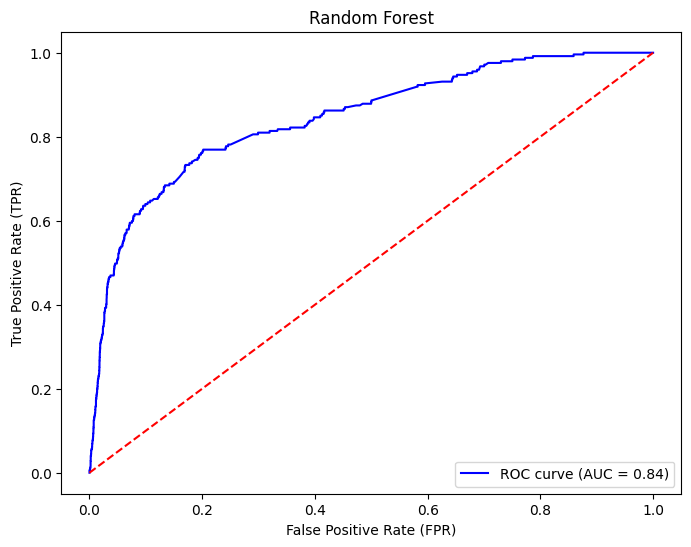

In [ ]:
pandas_df = predictions.select("probability", "HadHeartAttack_index").toPandas()
probabilities = pandas_df["probability"].apply(lambda x: x[:2])
labels = pandas_df["HadHeartAttack_index"]

from sklearn.metrics import roc_curve, roc_auc_score

# Extract probabilities for the positive class
positive_probs = probabilities.apply(lambda x: x[1])

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(labels, positive_probs)
auc = roc_auc_score(labels, positive_probs)

print(f"ROC AUC: {auc}")

plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Add labels and title
plt.title('Random Forest')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

plt.show()

In [ ]:
# Define the Logistic Regression
lr = LogisticRegression(labelCol="HadHeartAttack_index", featuresCol="features", predictionCol="prediction")

# Pipeline
pipeline = Pipeline(stages=[lr])

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="HadHeartAttack_index",  predictionCol="prediction", metricName="f1")

lr_cv = CrossValidator(estimator=pipeline,estimatorParamMaps=param_grid,evaluator=evaluator,numFolds=3,parallelism=6)

# Fit Model
lr_cv_model = lr_cv.fit(train_data)

# Best Model
lr_best_model = lr_cv_model.bestModel

lr_predictions = lr_best_model.transform(test_data)

In [ ]:
# Evaluate the model using F1 score on the test data
f1_score = evaluator.evaluate(lr_predictions)
print("F1 Score on test data: ", f1_score)

F1 Score on test data:  0.9133502152724607


In [ ]:
# Get the Logistic Regression model from the best pipeline
lr_model = lr_best_model.stages[0]

# Print the best parameters
print(f"Best Regularization Parameter (regParam): {lr_model._java_obj.getRegParam()}")
print(f"Best ElasticNet Parameter (elasticNetParam): {lr_model._java_obj.getElasticNetParam()}")

Best Regularization Parameter (regParam): 0.01
Best ElasticNet Parameter (elasticNetParam): 0.5


In [ ]:
lr_predictions.show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+-----------------------------------------------------------+----------------------------------------------------------------+----------+
|features                                                                                                                                                                                                                                      |HadHeartAttack_index|rawPrediction                                              |probability                                                     |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
valuator = BinaryClassificationEvaluator(labelCol="HadHeartAttack_index", rawPredictionCol="probability", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(lr_predictions)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9133502152724607


ROC AUC: 0.715847571764333


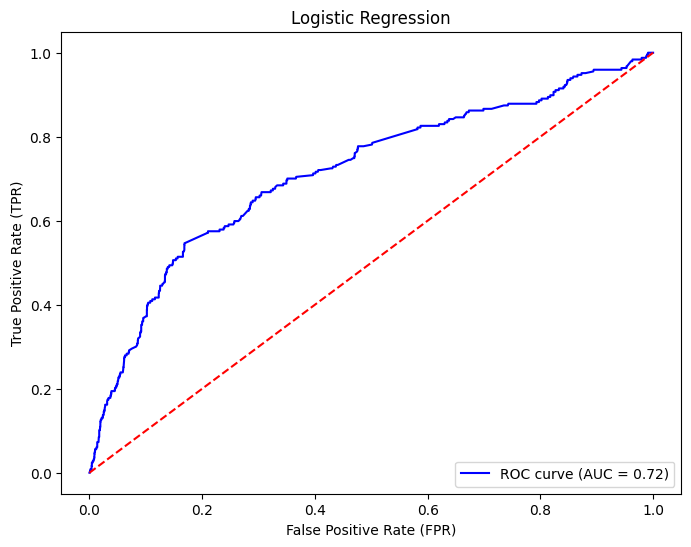

In [ ]:
pandas_df = lr_predictions.select("probability", "HadHeartAttack_index").toPandas()
probabilities = pandas_df["probability"].apply(lambda x: x[:2])
labels = pandas_df["HadHeartAttack_index"]

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Extract probabilities for the positive class
positive_probs = probabilities.apply(lambda x: x[1])

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(labels, positive_probs)
auc = roc_auc_score(labels, positive_probs)

print(f"ROC AUC: {auc}")

plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Add labels and title
plt.title('Logistic Regression')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

plt.show()

In [ ]:
from pyspark.ml.classification import GBTClassifier

# Gradient-Boosted Trees
gbt = GBTClassifier(labelCol="HadHeartAttack_index", featuresCol="features", predictionCol="prediction")

# Parameter Grid for GBT
param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [10, 15]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="HadHeartAttack_index",  predictionCol="prediction", metricName="f1")

# CrossValidator
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt,evaluator=evaluator,numFolds=3,parallelism=6)

# Fit GBT Model
gbt_cv_model = gbt_cv.fit(train_data)
gbt_best_model = gbt_cv_model.bestModel

# Make predictions on the test data
gbt_predictions = gbt_best_model.transform(test_data)

In [ ]:
# Evaluate the model using F1 score on the test data
f1_score = evaluator.evaluate(gbt_predictions)
print("F1 Score on test data: ", f1_score)

F1 Score on test data:  0.930483889981098


In [ ]:
# Retrieve the best parameters
best_max_depth = gbt_best_model.getOrDefault("maxDepth")
best_max_iter = gbt_best_model.getOrDefault("maxIter")

print(f"Best Parameters: maxDepth = {best_max_depth}, maxIter = {best_max_iter}")

Best Parameters: maxDepth = 10, maxIter = 50


In [ ]:
gbt_predictions.show(5,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+----------------------------------------+-----------------------------------------+----------+
|features                                                                                                                                                                                                                                      |HadHeartAttack_index|rawPrediction                           |probability                              |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+---------------------------

In [ ]:
valuator = BinaryClassificationEvaluator(labelCol="HadHeartAttack_index", rawPredictionCol="probability", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(gbt_predictions)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.930483889981098


ROC AUC: 0.7946430929305199


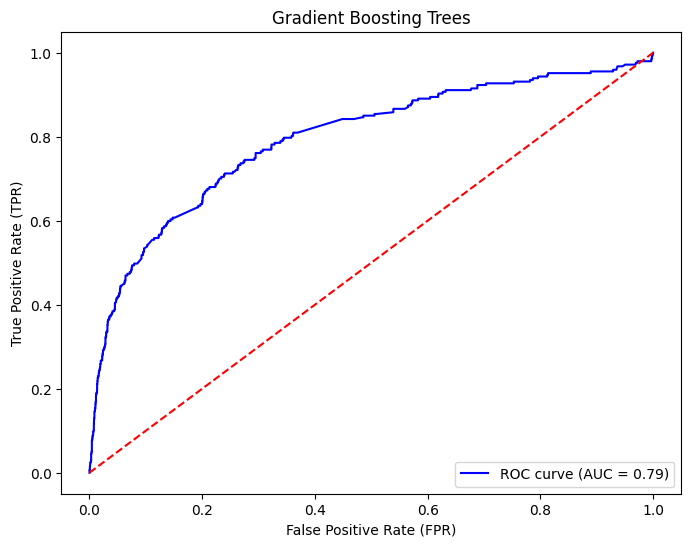

In [ ]:
pandas_df = gbt_predictions.select("probability", "HadHeartAttack_index").toPandas()
probabilities = pandas_df["probability"].apply(lambda x: x[:2])
labels = pandas_df["HadHeartAttack_index"]

from sklearn.metrics import roc_curve, roc_auc_score

# Extract probabilities for the positive class
positive_probs = probabilities.apply(lambda x: x[1])

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(labels, positive_probs)
auc = roc_auc_score(labels, positive_probs)

print(f"ROC AUC: {auc}")

plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Add labels and title
plt.title('Gradient Boosting Trees')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.show()

# Feature Importance

In [ ]:
importances = rf_best_model.featureImportances
print("Top 10 Important Features:")

# Extract indices and importance values as pairs and sort them by importance
sorted_importances = sorted(enumerate(importances), key=lambda x: x[1], reverse=True)

# Print the top 10 important features
for i, (idx, importance) in enumerate(sorted_importances[:10], start=1):
    print(f"Rank {i}: Feature {idx + 1}, Importance: {importance:.4f}")

Top 10 Important Features:
Rank 1: Feature 2, Importance: 0.0587
Rank 2: Feature 4, Importance: 0.0583
Rank 3: Feature 1, Importance: 0.0582
Rank 4: Feature 3, Importance: 0.0521
Rank 5: Feature 5, Importance: 0.0477
Rank 6: Feature 20, Importance: 0.0349
Rank 7: Feature 21, Importance: 0.0320
Rank 8: Feature 58, Importance: 0.0283
Rank 9: Feature 22, Importance: 0.0158
Rank 10: Feature 23, Importance: 0.0158


In [ ]:
feature_names = assembler.getInputCols()

# Pair feature names with their importance values and sort them by importance
sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print the top 15 important features
print("Top 15 Important Features:")
for rank, (feature, importance) in enumerate(sorted_features[:15], start=1):
    print(f"Rank {rank}: {feature}, Importance: {importance:.4f}")

Top 15 Important Features:
Rank 1: MentalHealthDays, Importance: 0.0587
Rank 2: BMI, Importance: 0.0583
Rank 3: PhysicalHealthDays, Importance: 0.0582
Rank 4: HeightInMeters, Importance: 0.0521
Rank 5: WeightInKilograms, Importance: 0.0477
Rank 6: DeafOrHardOfHearing_ohe, Importance: 0.0349
Rank 7: BlindOrVisionDifficulty_ohe, Importance: 0.0320
Rank 8: DifficultyConcentrating_ohe, Importance: 0.0158
Rank 9: DifficultyWalking_ohe, Importance: 0.0158
Rank 10: AgeCategory_ohe, Importance: 0.0128
Rank 11: RaceEthnicityCategory_ohe, Importance: 0.0127
Rank 12: AlcoholDrinkers_ohe, Importance: 0.0122
Rank 13: HadArthritis_ohe, Importance: 0.0117
Rank 14: DifficultyErrands_ohe, Importance: 0.0116
Rank 15: HadDiabetes_ohe, Importance: 0.0116


In [ ]:
importances = gbt_best_model.featureImportances

feature_names = assembler.getInputCols()

# Pair feature names with their importance values and sort them by importance
sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print the top 15 important features
print("Top 15 Important Features:")
for rank, (feature, importance) in enumerate(sorted_features[:15], start=1):
    print(f"Rank {rank}: {feature}, Importance: {importance:.4f}")

Top 15 Important Features:
Rank 1: BMI, Importance: 0.1008
Rank 2: HeightInMeters, Importance: 0.0880
Rank 3: WeightInKilograms, Importance: 0.0796
Rank 4: PhysicalHealthDays, Importance: 0.0764
Rank 5: MentalHealthDays, Importance: 0.0648
Rank 6: PhysicalActivities_ohe, Importance: 0.0184
Rank 7: DeafOrHardOfHearing_ohe, Importance: 0.0183
Rank 8: BlindOrVisionDifficulty_ohe, Importance: 0.0156
Rank 9: DifficultyConcentrating_ohe, Importance: 0.0113
Rank 10: LastCheckupTime_ohe, Importance: 0.0110
Rank 11: HadAsthma_ohe, Importance: 0.0108
Rank 12: HadStroke_ohe, Importance: 0.0103
Rank 13: Sex_ohe, Importance: 0.0101
Rank 14: HadAngina_ohe, Importance: 0.0092
Rank 15: HadArthritis_ohe, Importance: 0.0091
